In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score
from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


2024-06-27 15:56:26.574853: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 15:56:26.574930: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 15:56:26.574976: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 15:56:26.583846: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [8]:
import random

dynamic_1 = np.where(trainy == 0)[0]
dynamic_2 = np.where(trainy == 1)[0]
dynamic_3 = np.where(trainy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic)

trainX = X_train_all[dynamic]
trainy = y_train_all[dynamic]

/tmp/ipykernel_130/2880528613.py:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [9]:
dynamic_1 = np.where(testy == 0)[0]
dynamic_2 = np.where(testy == 1)[0]
dynamic_3 = np.where(testy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic_list)

testX = X_test_all[dynamic]
testy = y_test_all[dynamic]

/tmp/ipykernel_130/3566874998.py:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [10]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]]


In [11]:

trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [12]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (3285, 128, 9)
Y train shape:  (3285, 1)
Y train One hot shape:  (3285, 3)
X test shape:  (1387, 128, 9)
Y test shape:  (1387, 1)
Y test One hot shape:  (1387, 3)


In [13]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [14]:
n_steps = 4
n_features = trainX.shape[2]
n_length = 32

trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))
print(trainX.shape,testX.shape)

(3285, 4, 32, 9) (1387, 4, 32, 9)


In [15]:
n_timesteps, n_features, n_outputs = n_steps * n_length, trainX.shape[3], testy_one_hot.shape[1]

# CNN1 - LSTM1

In [16]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2024-06-27 15:56:33.451704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:48:00.0, compute capability: 8.0
2024-06-27 15:56:33.454102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:4c:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 30, 64)      1792      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, None, 30, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 15, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, None, 960)         0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               4

In [17]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20


2024-06-27 15:56:36.715047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-06-27 15:56:37.764583: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9f00791430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-27 15:56:37.764627: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-06-27 15:56:37.764636: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-06-27 15:56:37.770210: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-27 15:56:37.854729: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 [==============================] - 5s 30ms/step - loss: 0.9923 - accuracy: 0.5002 - val_loss: 0.7851 - val_accuracy: 0.5994
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.5857 - accuracy: 0.7623 - val_loss: 0.3667 - val_accuracy: 0.8945
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.2774 - accuracy: 0.8977 - val_loss: 0.1609 - val_accuracy: 0.9635
Epoch 4/20
26/26 [==============================] - 0s 6ms/step - loss: 0.1272 - accuracy: 0.9571 - val_loss: 0.0606 - val_accuracy: 0.9868
Epoch 5/20
26/26 [==============================] - 0s 6ms/step - loss: 0.0748 - accuracy: 0.9750 - val_loss: 0.0396 - val_accuracy: 0.9929
Epoch 6/20
26/26 [==============================] - 0s 6ms/step - loss: 0.0344 - accuracy: 0.9887 - val_loss: 0.0234 - val_accuracy: 0.9909
Epoch 7/20
26/26 [==============================] - 0s 6ms/step - loss: 0.0311 - accuracy: 0.9900 - val_loss: 0.0157 - val_accuracy: 0.9990
Epoch 8/20
26/26 [============

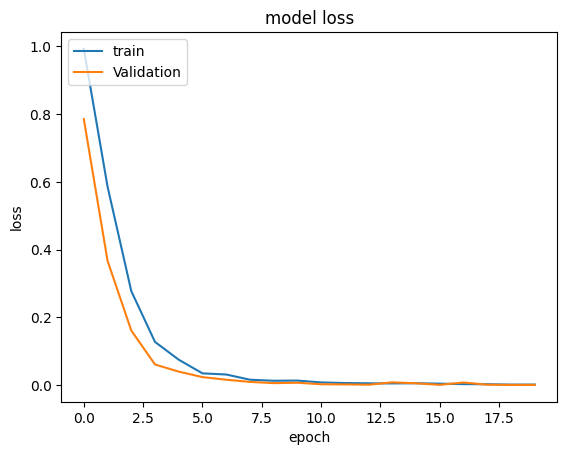

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

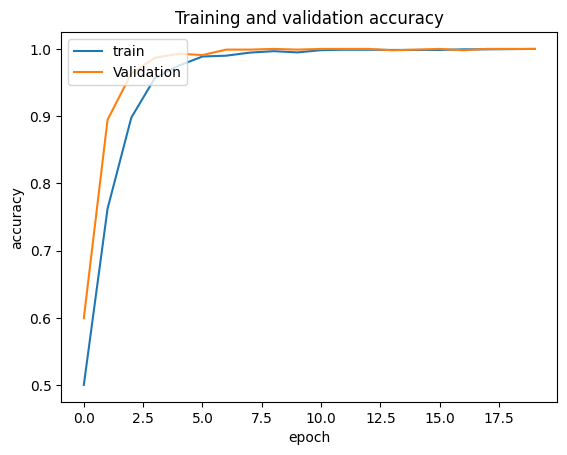

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 0s 2ms/step
0.9488103821196827
0.9494723083689075


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

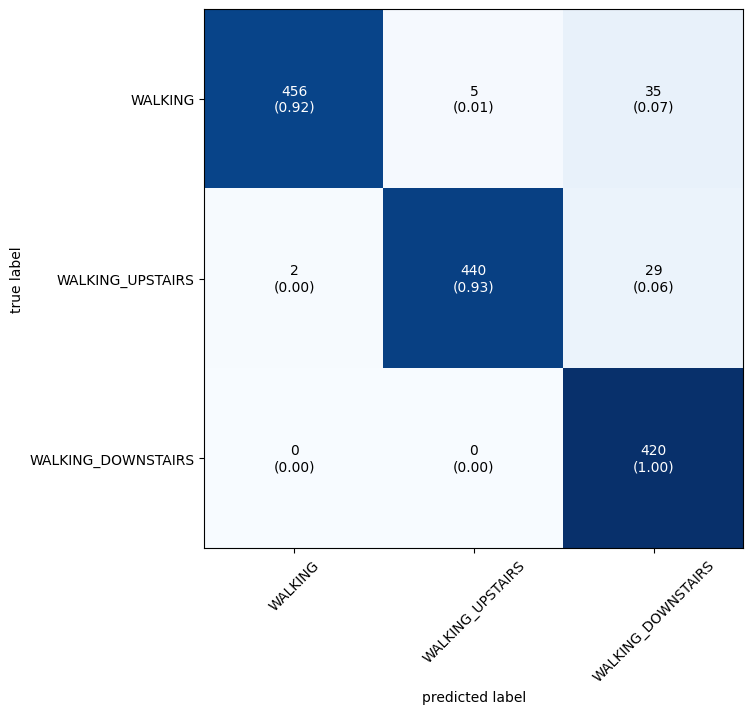

In [20]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# Layer 3

# CNN 3

In [21]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))

# Global Average Pooling to remove the time dimension and keep only features dimension
model.add(GlobalAveragePooling1D())

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, None, 30, 64)      1792      
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, None, 28, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, None, 28, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, None, 14, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_8 (TimeDi  (None, None, 12, 64)     

In [22]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
26/26 [==============================] - 3s 20ms/step - loss: 1.0038 - accuracy: 0.4925 - val_loss: 0.8668 - val_accuracy: 0.6339
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.5285 - accuracy: 0.7881 - val_loss: 0.4076 - val_accuracy: 0.9057
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.2252 - accuracy: 0.9272 - val_loss: 0.2006 - val_accuracy: 0.9746
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0794 - accuracy: 0.9781 - val_loss: 0.0923 - val_accuracy: 0.9949
Epoch 5/20
26/26 [==============================] - 0s 6ms/step - loss: 0.0422 - accuracy: 0.9860 - val_loss: 0.0577 - val_accuracy: 0.9970
Epoch 6/20
26/26 [==============================] - 0s 6ms/step - loss: 0.0209 - accuracy: 0.9963 - val_loss: 0.0385 - val_accuracy: 0.9990
Epoch 7/20
26/26 [==============================] - 0s 6ms/step - loss: 0.0256 - accuracy: 0.9930 - val_loss: 0.0343 - val_accuracy: 0.9970
Epoch 8/20
26/26 [=

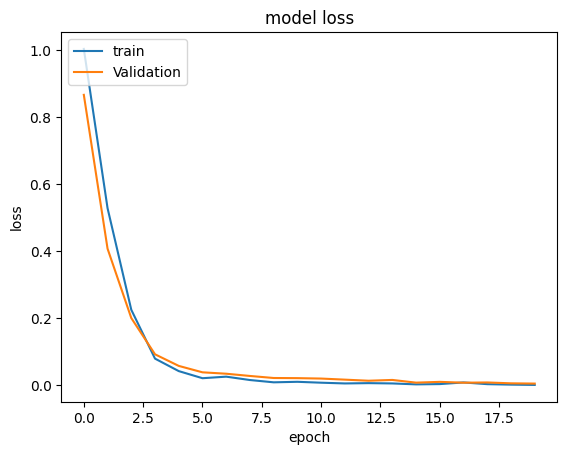

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

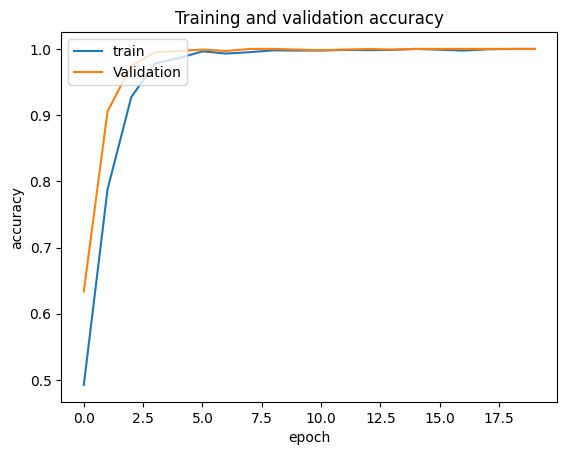

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 0s 2ms/step
0.9639509733237203
0.964361185867349


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

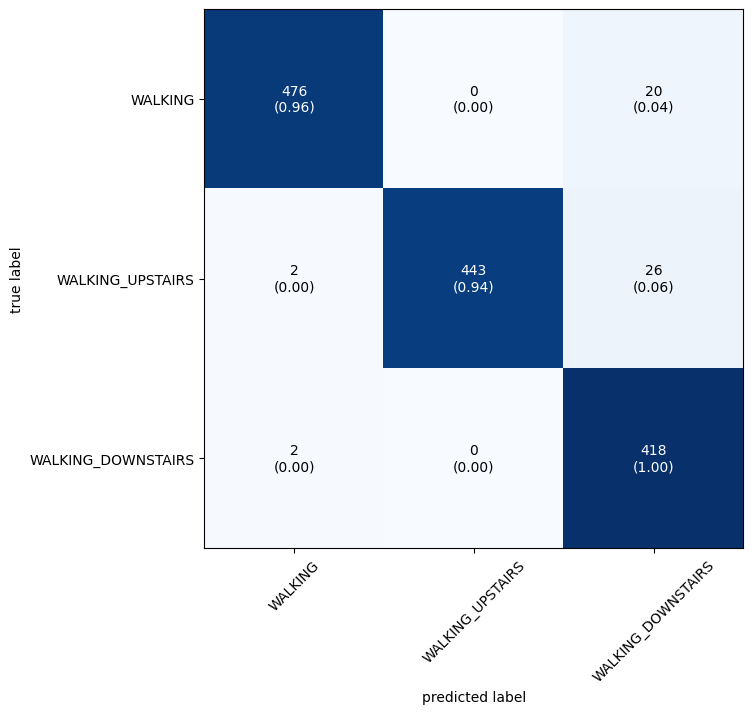

In [25]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# CNN 1 - LSTM2



In [26]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, None, 30, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, None, 15, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, None, 960)         0         
 istributed)                                                     
                                                                 
 lstm_1 (LSTM)               (None, None, 100)        

In [27]:

# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
26/26 [==============================] - 4s 30ms/step - loss: 1.0124 - accuracy: 0.4743 - val_loss: 0.8064 - val_accuracy: 0.6694
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.6313 - accuracy: 0.7397 - val_loss: 0.4193 - val_accuracy: 0.8712
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.3126 - accuracy: 0.8858 - val_loss: 0.2134 - val_accuracy: 0.9391
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1640 - accuracy: 0.9455 - val_loss: 0.1438 - val_accuracy: 0.9513
Epoch 5/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0965 - accuracy: 0.9653 - val_loss: 0.0583 - val_accuracy: 0.9807
Epoch 6/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0599 - accuracy: 0.9787 - val_loss: 0.0257 - val_accuracy: 0.9980
Epoch 7/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0365 - accuracy: 0.9866 - val_loss: 0.0192 - val_accuracy: 0.9959
Epoch 8/20
26/26 [=

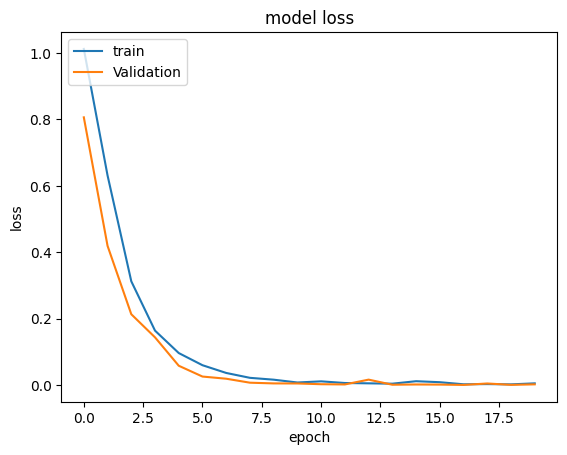

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

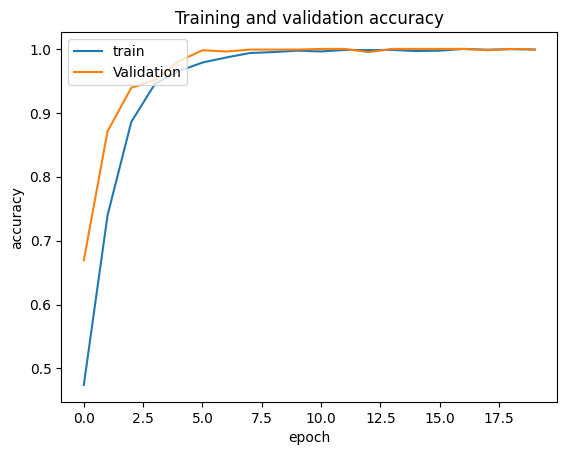

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 2ms/step
0.9387166546503244
0.9398733339070013


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

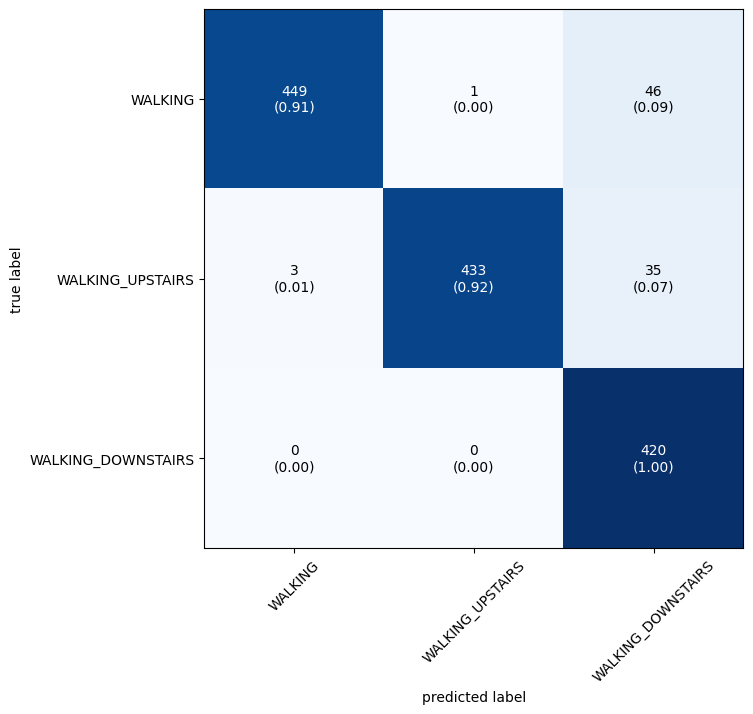

In [30]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# CNN2 - LSTM1

In [31]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_18 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, None, 896)        

In [32]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
26/26 [==============================] - 3s 24ms/step - loss: 0.8903 - accuracy: 0.5881 - val_loss: 0.5856 - val_accuracy: 0.7850
Epoch 2/20
26/26 [==============================] - 0s 6ms/step - loss: 0.4022 - accuracy: 0.8533 - val_loss: 0.2629 - val_accuracy: 0.9320
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1559 - accuracy: 0.9510 - val_loss: 0.0858 - val_accuracy: 0.9787
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1189 - accuracy: 0.9565 - val_loss: 0.0775 - val_accuracy: 0.9858
Epoch 5/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0684 - accuracy: 0.9784 - val_loss: 0.0390 - val_accuracy: 0.9959
Epoch 6/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0367 - accuracy: 0.9900 - val_loss: 0.0221 - val_accuracy: 0.9959
Epoch 7/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0211 - accuracy: 0.9930 - val_loss: 0.0155 - val_accuracy: 0.9980
Epoch 8/20
26/26 [=

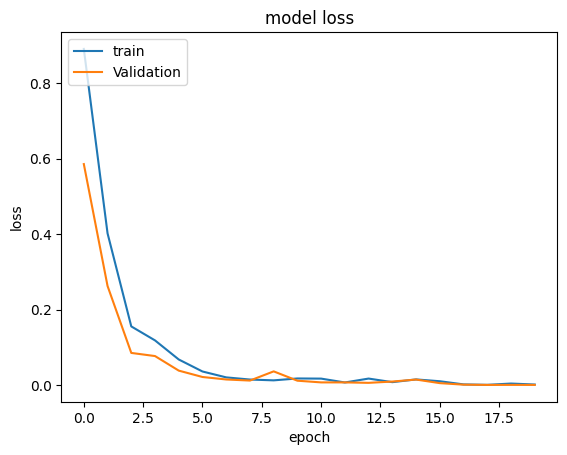

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

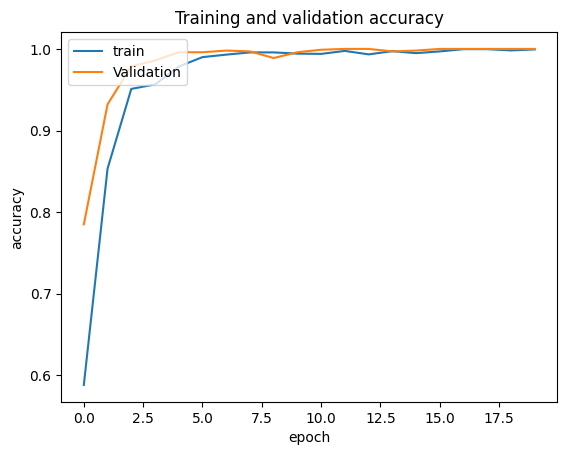

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 0s 2ms/step
0.9495313626532084
0.9498075699308707


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

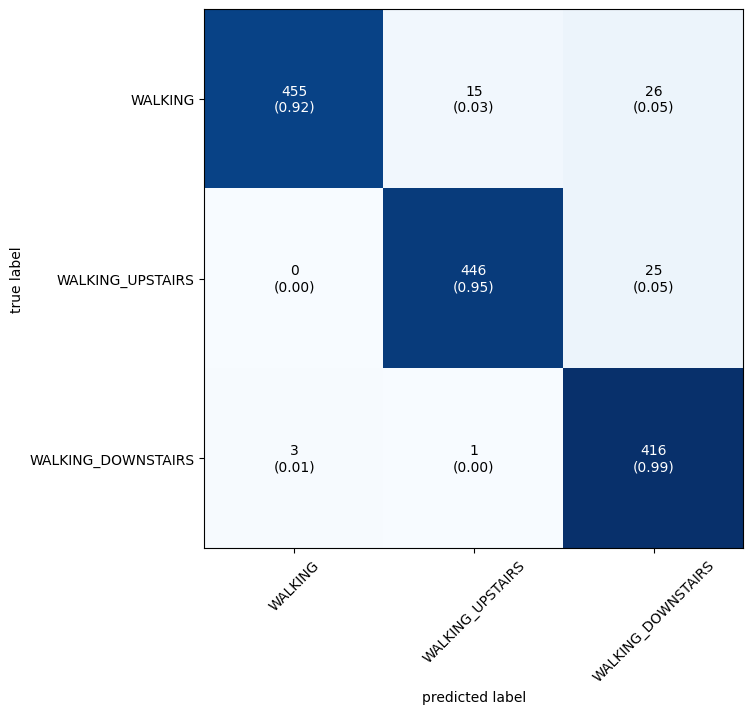

In [35]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

#  LSTM3

In [36]:
# define model
model = Sequential()
model.add(TimeDistributed(LSTM(100, return_sequences=True), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100, return_sequences=True)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100)))

# Use TimeDistributed to flatten the LSTM outputs
model.add(TimeDistributed(Flatten()))

# Pool the time dimension
model.add(GlobalAveragePooling1D())

# Adding Dense layers
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_21 (TimeD  (None, None, 32, 100)     44000     
 istributed)                                                     
                                                                 
 time_distributed_22 (TimeD  (None, None, 32, 100)     0         
 istributed)                                                     
                                                                 
 time_distributed_23 (TimeD  (None, None, 32, 100)     80400     
 istributed)                                                     
                                                                 
 time_distributed_24 (TimeD  (None, None, 32, 100)     0         
 istributed)                                                     
                                                                 
 time_distributed_25 (TimeD  (None, None, 100)        

In [37]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
26/26 [==============================] - 5s 45ms/step - loss: 0.9568 - accuracy: 0.5403 - val_loss: 0.7436 - val_accuracy: 0.7079
Epoch 2/20
26/26 [==============================] - 1s 25ms/step - loss: 0.5959 - accuracy: 0.7811 - val_loss: 0.4558 - val_accuracy: 0.8185
Epoch 3/20
26/26 [==============================] - 0s 12ms/step - loss: 0.2923 - accuracy: 0.8980 - val_loss: 0.1237 - val_accuracy: 0.9635
Epoch 4/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1486 - accuracy: 0.9498 - val_loss: 0.0638 - val_accuracy: 0.9787
Epoch 5/20
26/26 [==============================] - 0s 12ms/step - loss: 0.0632 - accuracy: 0.9805 - val_loss: 0.0269 - val_accuracy: 0.9929
Epoch 6/20
26/26 [==============================] - 0s 12ms/step - loss: 0.0477 - accuracy: 0.9845 - val_loss: 0.0298 - val_accuracy: 0.9888
Epoch 7/20
26/26 [==============================] - 0s 12ms/step - loss: 0.0271 - accuracy: 0.9918 - val_loss: 0.0129 - val_accuracy: 0.9949
Epoch 8/20
26

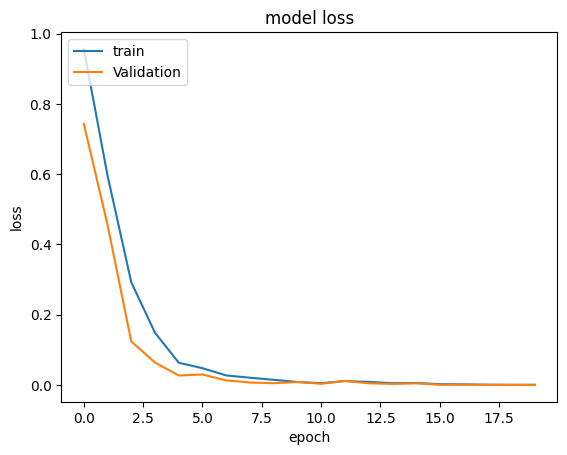

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

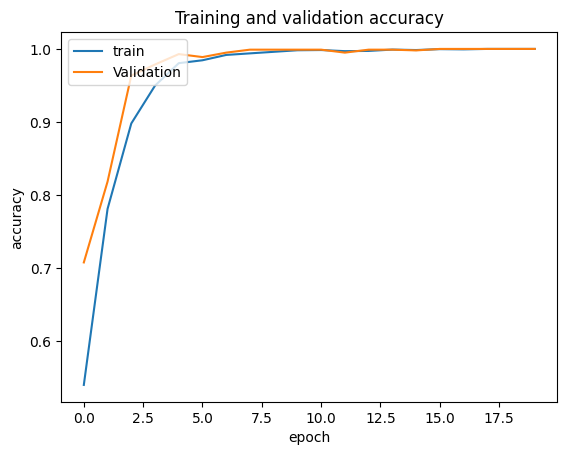

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 4ms/step
0.9271809661139149
0.9262038036416128


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

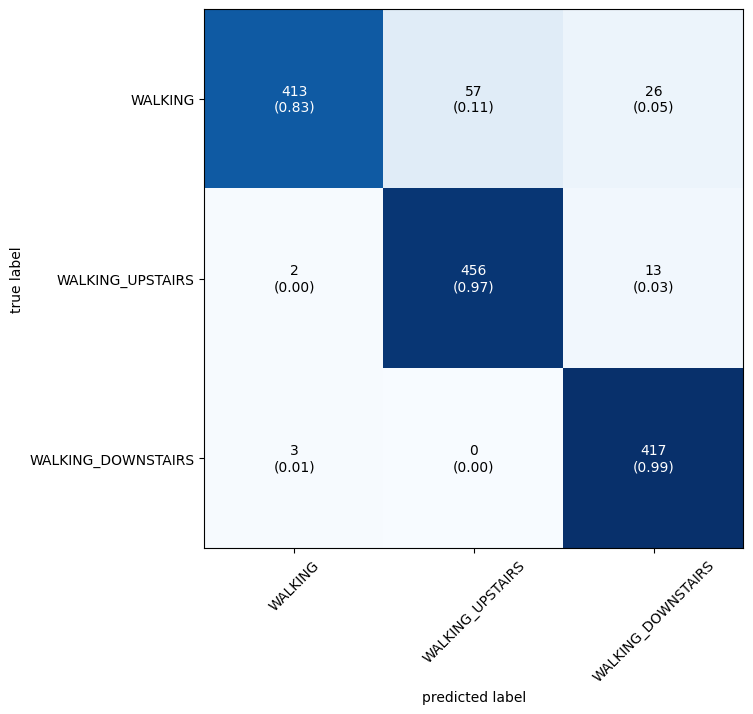

In [40]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# Layer4

# CNN4

In [41]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))

# Global Average Pooling to remove the time dimension and keep only features dimension
model.add(GlobalAveragePooling1D())

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_27 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_28 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_29 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_30 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_31 (TimeD  (None, None, 12, 64)     

In [42]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
26/26 [==============================] - 2s 17ms/step - loss: 1.0447 - accuracy: 0.4533 - val_loss: 0.9831 - val_accuracy: 0.5923
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.7001 - accuracy: 0.6910 - val_loss: 0.6470 - val_accuracy: 0.8337
Epoch 3/20
26/26 [==============================] - 0s 6ms/step - loss: 0.3661 - accuracy: 0.8624 - val_loss: 0.4000 - val_accuracy: 0.9402
Epoch 4/20
26/26 [==============================] - 0s 6ms/step - loss: 0.1518 - accuracy: 0.9507 - val_loss: 0.2234 - val_accuracy: 0.9604
Epoch 5/20
26/26 [==============================] - 0s 6ms/step - loss: 0.0925 - accuracy: 0.9696 - val_loss: 0.1662 - val_accuracy: 0.9939
Epoch 6/20
26/26 [==============================] - 0s 6ms/step - loss: 0.0604 - accuracy: 0.9799 - val_loss: 0.1111 - val_accuracy: 0.9970
Epoch 7/20
26/26 [==============================] - 0s 6ms/step - loss: 0.0282 - accuracy: 0.9924 - val_loss: 0.0888 - val_accuracy: 0.9949
Epoch 8/20
26/26 [=

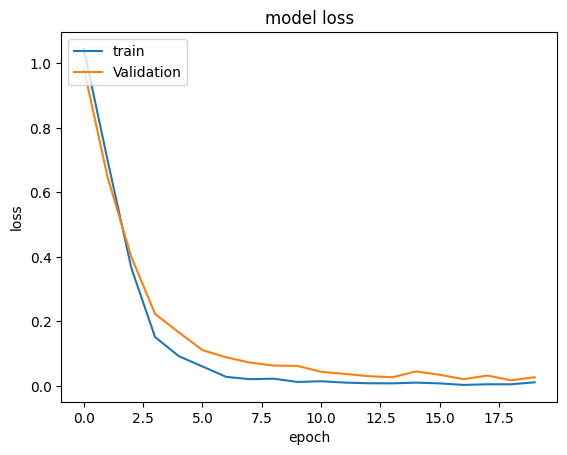

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

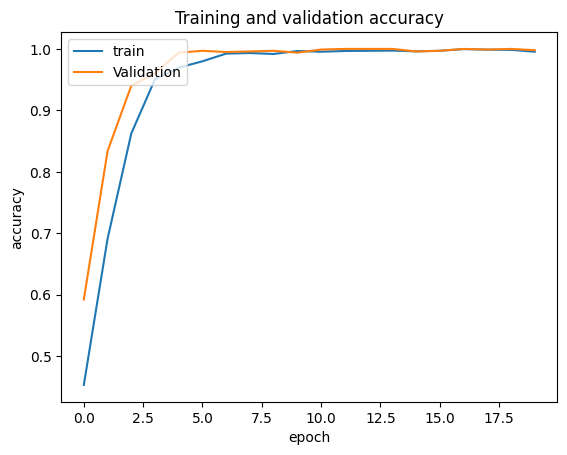

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 0s 2ms/step
0.9509733237202596
0.9508992855994363


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

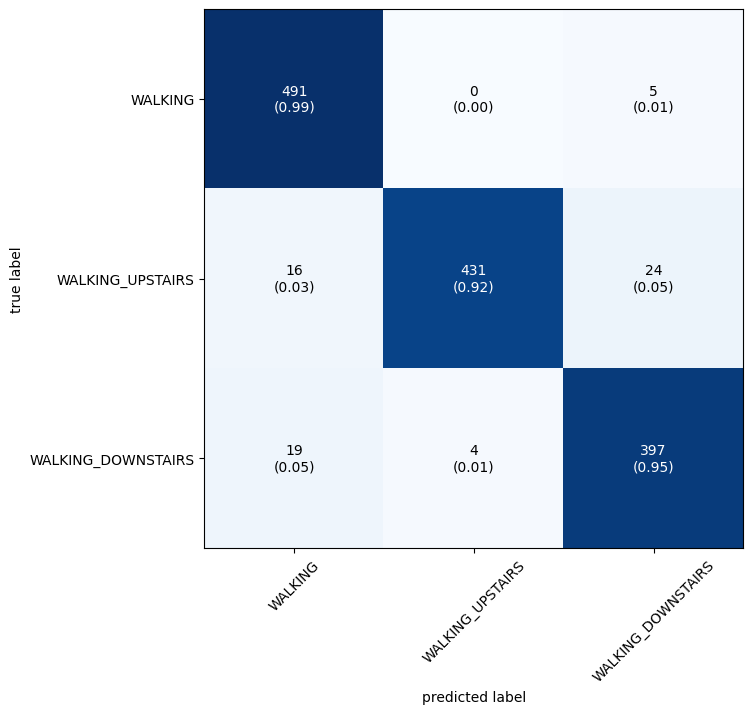

In [45]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# CNN1 - LSTM3

In [46]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))


model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_38 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_39 (TimeD  (None, None, 30, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_40 (TimeD  (None, None, 15, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_41 (TimeD  (None, None, 960)         0         
 istributed)                                                     
                                                                 
 lstm_7 (LSTM)               (None, None, 100)        

In [47]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
26/26 [==============================] - 5s 41ms/step - loss: 1.0651 - accuracy: 0.4381 - val_loss: 0.9415 - val_accuracy: 0.5933
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.6395 - accuracy: 0.7498 - val_loss: 0.4101 - val_accuracy: 0.8621
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 0.2920 - accuracy: 0.9014 - val_loss: 0.2199 - val_accuracy: 0.9371
Epoch 4/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1403 - accuracy: 0.9534 - val_loss: 0.0789 - val_accuracy: 0.9757
Epoch 5/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0892 - accuracy: 0.9696 - val_loss: 0.1449 - val_accuracy: 0.9361
Epoch 6/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0789 - accuracy: 0.9726 - val_loss: 0.0381 - val_accuracy: 0.9878
Epoch 7/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0335 - accuracy: 0.9890 - val_loss: 0.0204 - val_accuracy: 0.9959
Epoch 8/20
26/26 [=

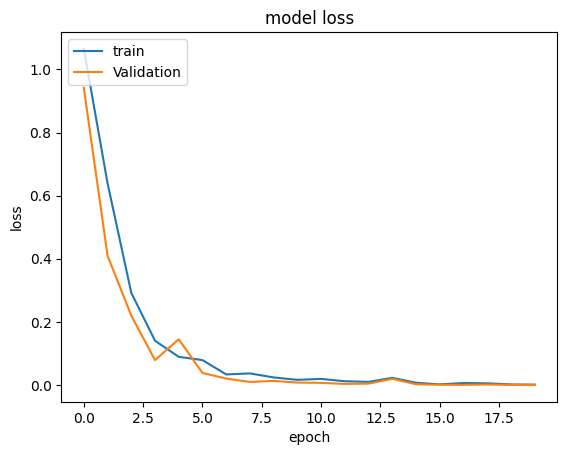

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

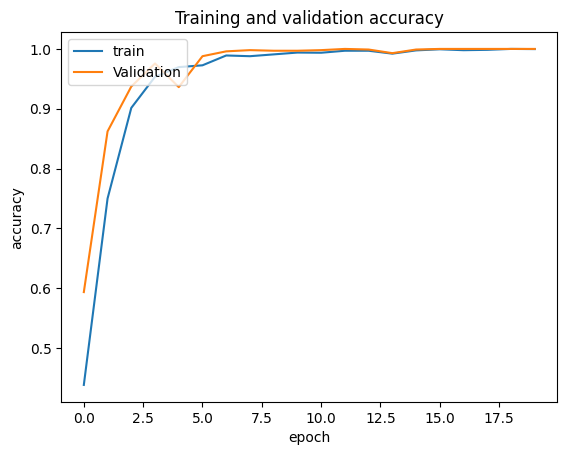

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 2ms/step
0.9740447007930786
0.9742356405345854


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

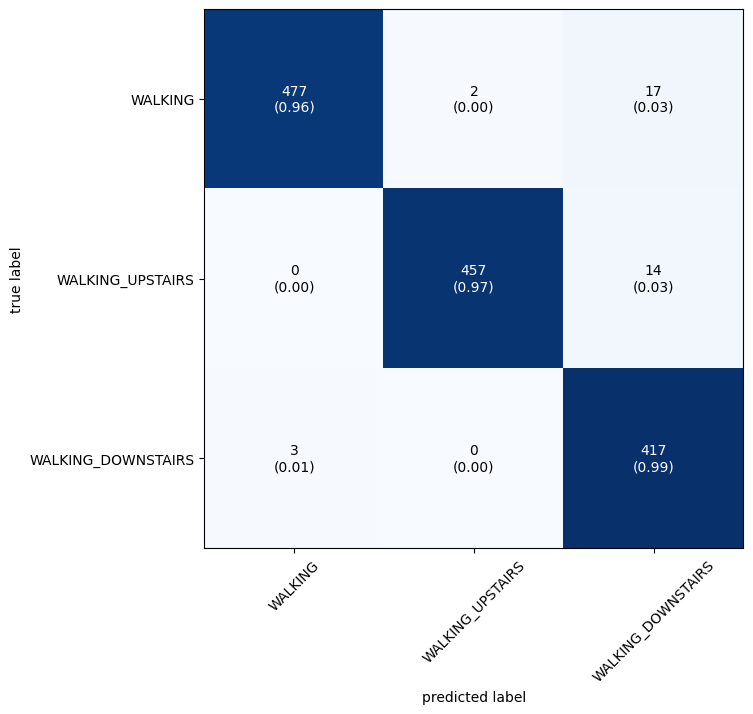

In [50]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# CNN2 - LSTM2

In [51]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_42 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_43 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_44 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_45 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_46 (TimeD  (None, None, 896)        

In [52]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
26/26 [==============================] - 4s 31ms/step - loss: 0.9974 - accuracy: 0.4956 - val_loss: 0.7621 - val_accuracy: 0.7069
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.4889 - accuracy: 0.8079 - val_loss: 0.3109 - val_accuracy: 0.8834
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.2013 - accuracy: 0.9342 - val_loss: 0.1381 - val_accuracy: 0.9686
Epoch 4/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0922 - accuracy: 0.9738 - val_loss: 0.0443 - val_accuracy: 0.9939
Epoch 5/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0583 - accuracy: 0.9839 - val_loss: 0.0550 - val_accuracy: 0.9838
Epoch 6/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0545 - accuracy: 0.9811 - val_loss: 0.0388 - val_accuracy: 0.9878
Epoch 7/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0288 - accuracy: 0.9884 - val_loss: 0.0203 - val_accuracy: 0.9949
Epoch 8/20
26/26 [=

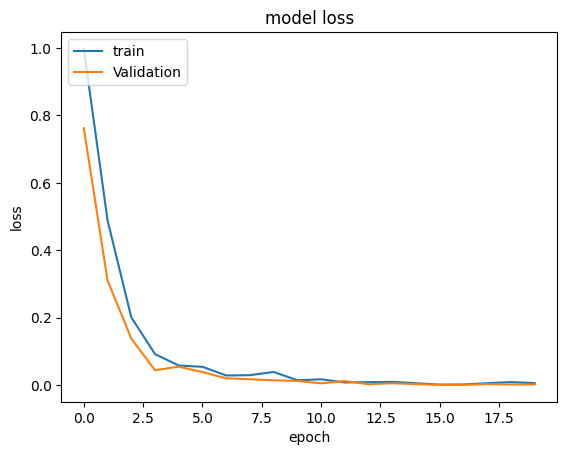

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

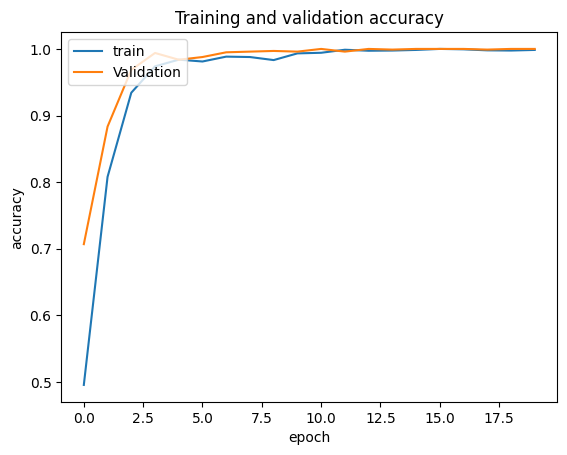

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 2ms/step
0.9387166546503244
0.9390563964599324


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

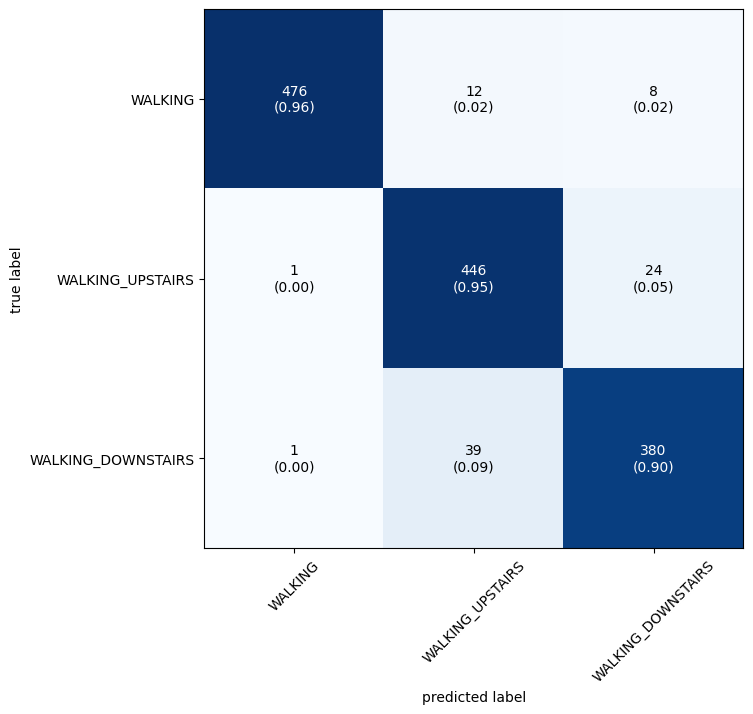

In [55]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# CNN3 - LSTM1

In [56]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_47 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_48 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_49 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_50 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_51 (TimeD  (None, None, 12, 64)     

In [57]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
26/26 [==============================] - 3s 24ms/step - loss: 0.9770 - accuracy: 0.5257 - val_loss: 0.7379 - val_accuracy: 0.7525
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.3875 - accuracy: 0.8615 - val_loss: 0.2064 - val_accuracy: 0.9696
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1351 - accuracy: 0.9549 - val_loss: 0.1589 - val_accuracy: 0.9838
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0558 - accuracy: 0.9823 - val_loss: 0.0706 - val_accuracy: 0.9970
Epoch 5/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0313 - accuracy: 0.9903 - val_loss: 0.0774 - val_accuracy: 0.9888
Epoch 6/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0176 - accuracy: 0.9945 - val_loss: 0.0370 - val_accuracy: 0.9990
Epoch 7/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0147 - accuracy: 0.9954 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 8/20
26/26 [=

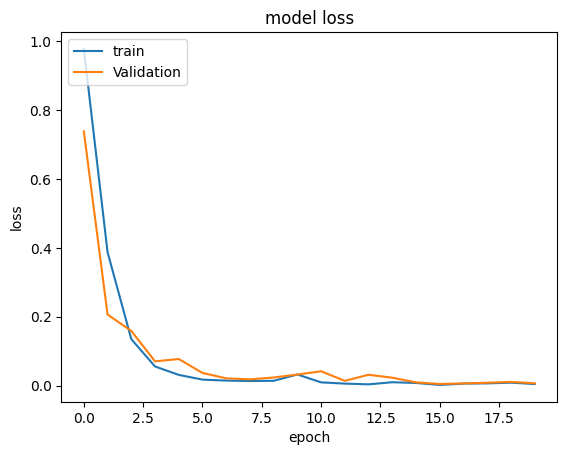

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

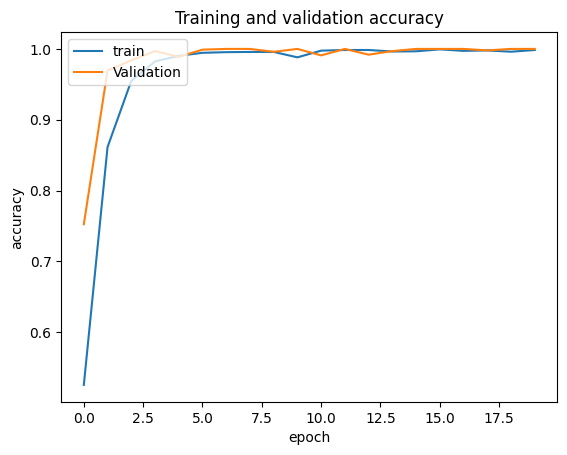

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 0s 2ms/step
0.9581831290555155
0.9587605389830619


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

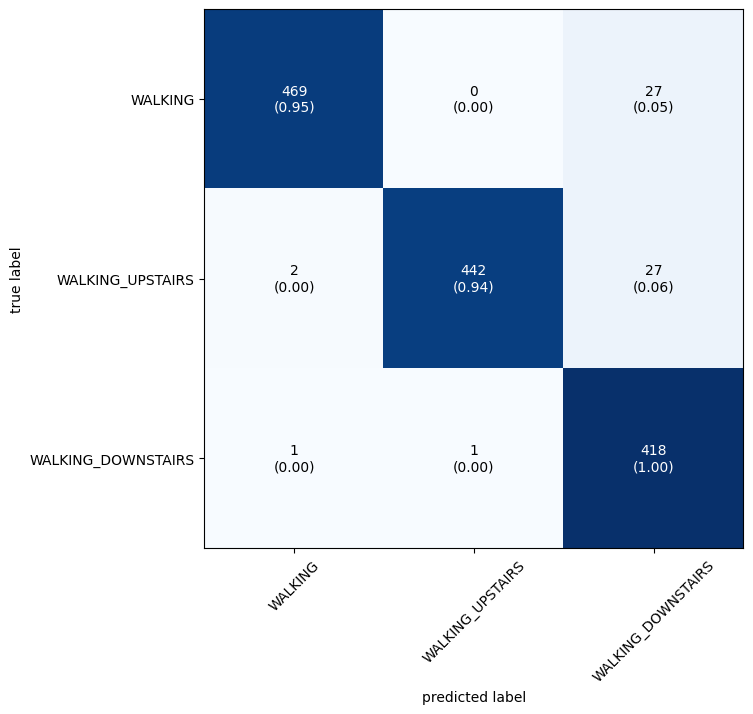

In [60]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# LSTM4

In [61]:
# define model
model = Sequential()
model.add(TimeDistributed(LSTM(100, return_sequences=True), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100, return_sequences=True)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100, return_sequences=True)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100)))

# Use TimeDistributed to flatten the LSTM outputs
model.add(TimeDistributed(Flatten()))

# Pool the time dimension
model.add(GlobalAveragePooling1D())

# Adding Dense layers
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_55 (TimeD  (None, None, 32, 100)     44000     
 istributed)                                                     
                                                                 
 time_distributed_56 (TimeD  (None, None, 32, 100)     0         
 istributed)                                                     
                                                                 
 time_distributed_57 (TimeD  (None, None, 32, 100)     80400     
 istributed)                                                     
                                                                 
 time_distributed_58 (TimeD  (None, None, 32, 100)     0         
 istributed)                                                     
                                                                 
 time_distributed_59 (TimeD  (None, None, 32, 100)    

In [62]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
26/26 [==============================] - 7s 76ms/step - loss: 0.9834 - accuracy: 0.4992 - val_loss: 0.8974 - val_accuracy: 0.5771
Epoch 2/20
26/26 [==============================] - 0s 15ms/step - loss: 0.6987 - accuracy: 0.7017 - val_loss: 0.4465 - val_accuracy: 0.8489
Epoch 3/20
26/26 [==============================] - 0s 15ms/step - loss: 0.3536 - accuracy: 0.8758 - val_loss: 0.1660 - val_accuracy: 0.9503
Epoch 4/20
26/26 [==============================] - 0s 15ms/step - loss: 0.1406 - accuracy: 0.9501 - val_loss: 0.0843 - val_accuracy: 0.9696
Epoch 5/20
26/26 [==============================] - 0s 15ms/step - loss: 0.0828 - accuracy: 0.9735 - val_loss: 0.0510 - val_accuracy: 0.9817
Epoch 6/20
26/26 [==============================] - 0s 15ms/step - loss: 0.0453 - accuracy: 0.9842 - val_loss: 0.0312 - val_accuracy: 0.9888
Epoch 7/20
26/26 [==============================] - 0s 16ms/step - loss: 0.0264 - accuracy: 0.9918 - val_loss: 0.0191 - val_accuracy: 0.9929
Epoch 8/20
26

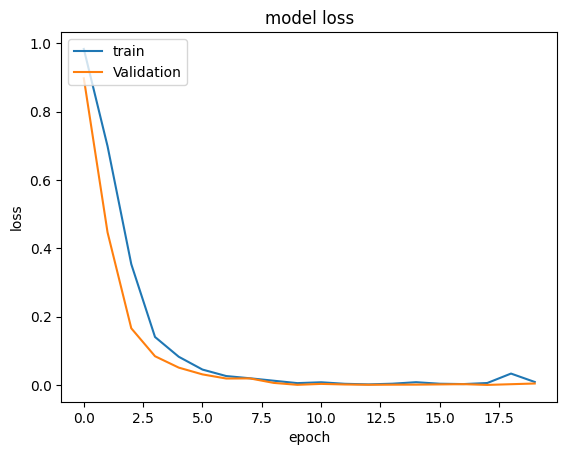

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

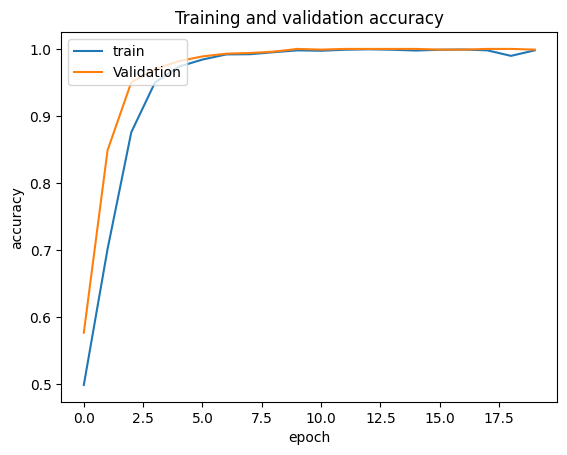

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 5ms/step
0.9329488103821196
0.9322122999944933


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

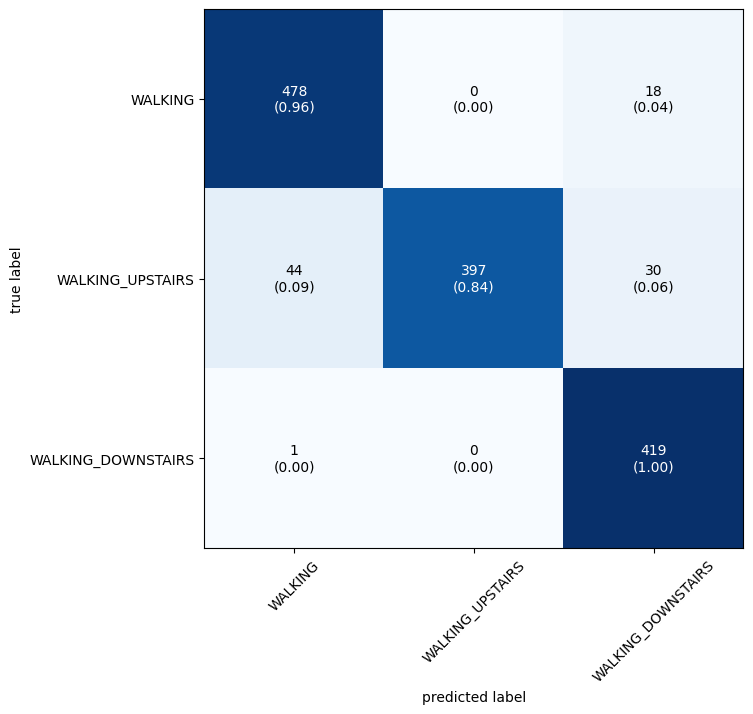

In [65]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# Layer5

# CNN 5

In [66]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))

# Global Average Pooling to remove the time dimension and keep only features dimension
model.add(GlobalAveragePooling1D())

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_63 (TimeD  (None, None, 32, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_64 (TimeD  (None, None, 32, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_65 (TimeD  (None, None, 32, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_66 (TimeD  (None, None, 16, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_67 (TimeD  (None, None, 16, 64)    

In [67]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
26/26 [==============================] - 3s 25ms/step - loss: 1.0064 - accuracy: 0.4654 - val_loss: 0.9267 - val_accuracy: 0.6978
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.5977 - accuracy: 0.7601 - val_loss: 0.6192 - val_accuracy: 0.8905
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.2702 - accuracy: 0.9014 - val_loss: 0.3580 - val_accuracy: 0.9777
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1077 - accuracy: 0.9610 - val_loss: 0.2431 - val_accuracy: 0.9878
Epoch 5/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0488 - accuracy: 0.9857 - val_loss: 0.1648 - val_accuracy: 0.9980
Epoch 6/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0246 - accuracy: 0.9930 - val_loss: 0.1200 - val_accuracy: 0.9939
Epoch 7/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0200 - accuracy: 0.9933 - val_loss: 0.1186 - val_accuracy: 0.9929
Epoch 8/20
26/26 [=

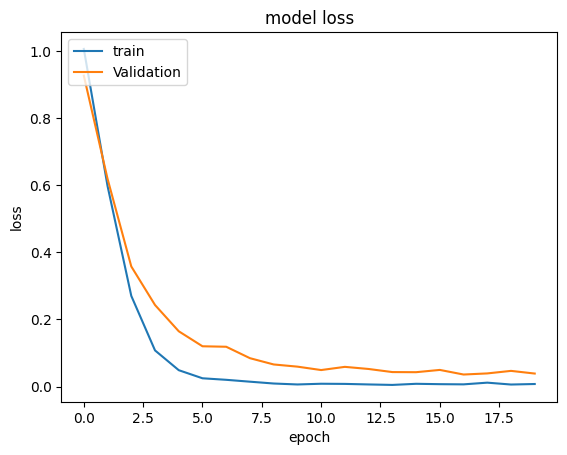

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

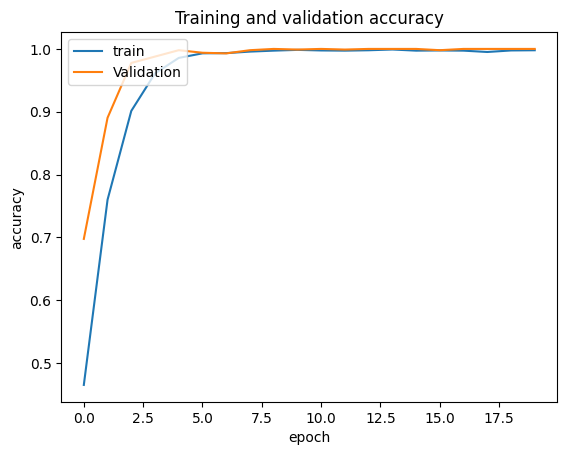

In [69]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 0s 2ms/step
0.9653929343907715
0.9656998613346419


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

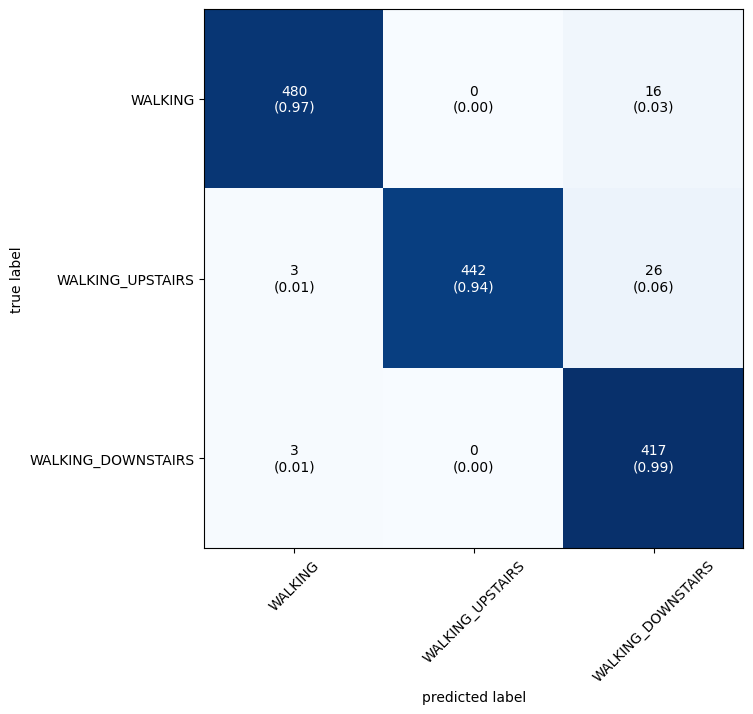

In [70]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# C4 L1

In [71]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_77 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_78 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_79 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_80 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_81 (TimeD  (None, None, 12, 64)    

In [72]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
26/26 [==============================] - 3s 26ms/step - loss: 1.0229 - accuracy: 0.4709 - val_loss: 0.8100 - val_accuracy: 0.7465
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.5201 - accuracy: 0.8003 - val_loss: 0.3882 - val_accuracy: 0.8874
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1867 - accuracy: 0.9391 - val_loss: 0.1762 - val_accuracy: 0.9544
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0992 - accuracy: 0.9686 - val_loss: 0.0850 - val_accuracy: 0.9868
Epoch 5/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0513 - accuracy: 0.9848 - val_loss: 0.0514 - val_accuracy: 0.9959
Epoch 6/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0235 - accuracy: 0.9933 - val_loss: 0.0285 - val_accuracy: 0.9990
Epoch 7/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0153 - accuracy: 0.9948 - val_loss: 0.0208 - val_accuracy: 0.9970
Epoch 8/20
26/26 [=

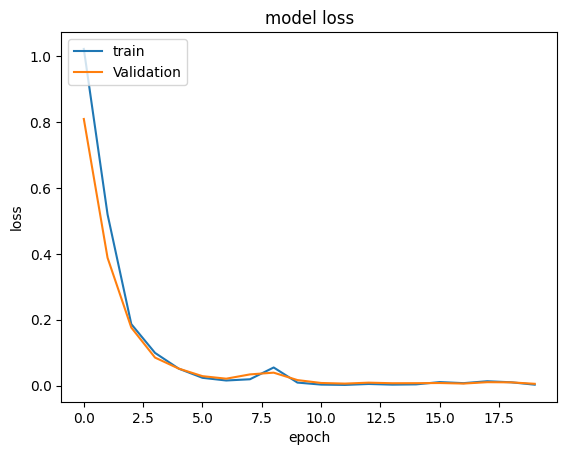

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

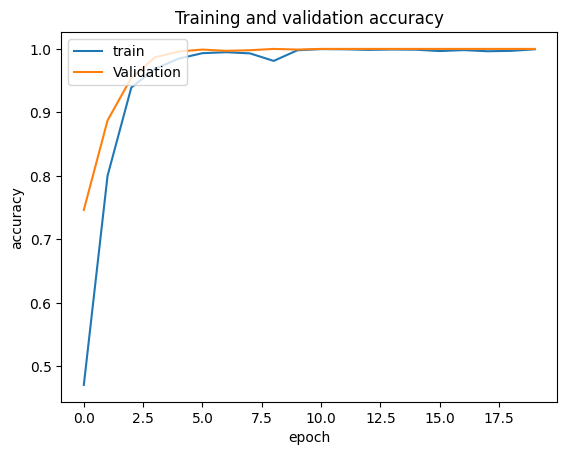

In [74]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 0s 2ms/step
0.9567411679884643
0.9569075254068212


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

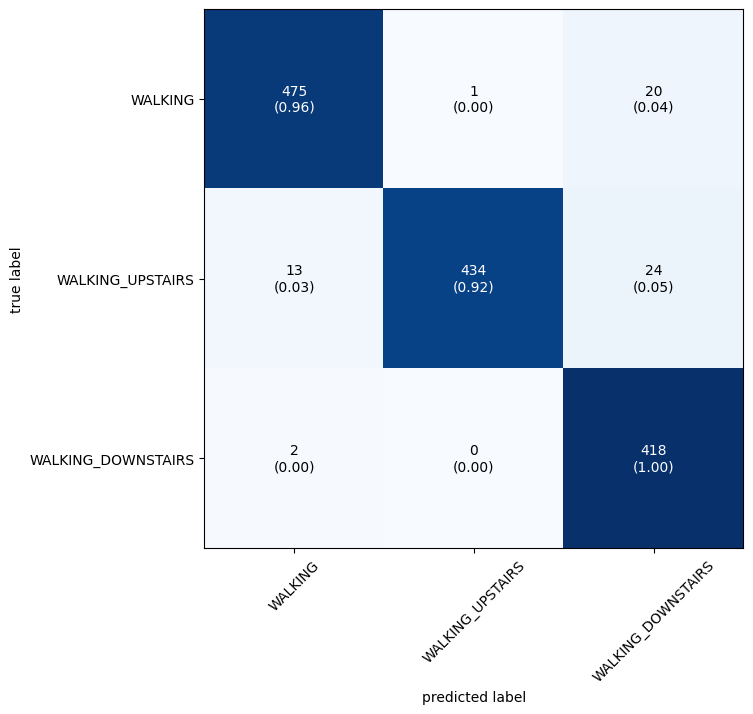

In [75]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# CNN3 - LSTM2

In [76]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_86 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_87 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_88 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_89 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_90 (TimeD  (None, None, 12, 64)    

In [77]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
26/26 [==============================] - 5s 33ms/step - loss: 1.0237 - accuracy: 0.4584 - val_loss: 0.8781 - val_accuracy: 0.6075
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.5723 - accuracy: 0.7668 - val_loss: 0.4139 - val_accuracy: 0.8986
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 0.2616 - accuracy: 0.9102 - val_loss: 0.2255 - val_accuracy: 0.9442
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1067 - accuracy: 0.9644 - val_loss: 0.0808 - val_accuracy: 0.9919
Epoch 5/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0487 - accuracy: 0.9854 - val_loss: 0.0598 - val_accuracy: 0.9949
Epoch 6/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0687 - accuracy: 0.9763 - val_loss: 0.1104 - val_accuracy: 0.9696
Epoch 7/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0397 - accuracy: 0.9869 - val_loss: 0.0713 - val_accuracy: 0.9828
Epoch 8/20
26/26 [=

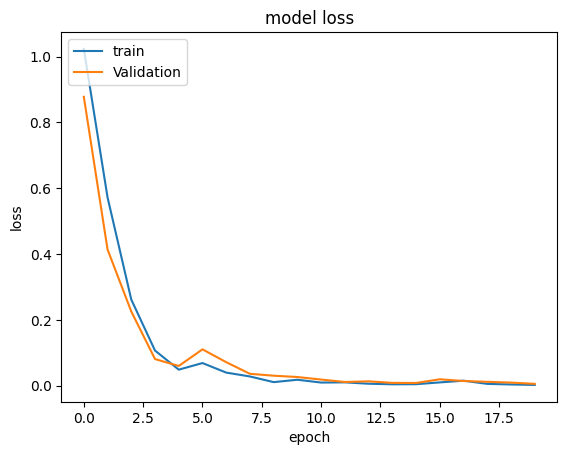

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

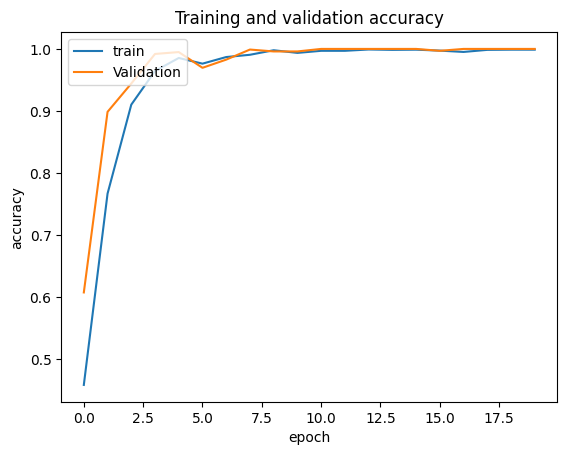

In [79]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 2ms/step
0.9509733237202596
0.9512619134906799


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

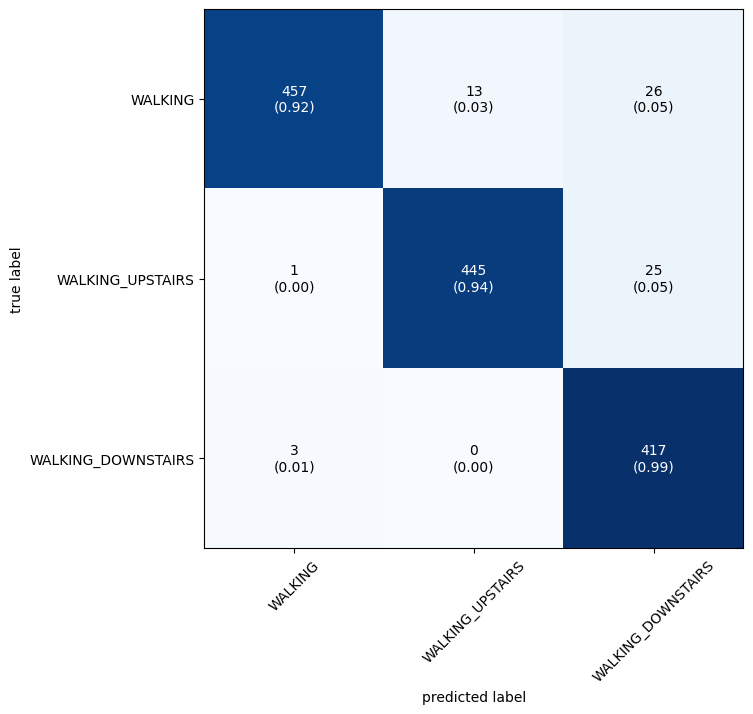

In [80]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# CNN2 - LSTM3

In [81]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))




model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_94 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_95 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_96 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_97 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_98 (TimeD  (None, None, 896)       

In [82]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
26/26 [==============================] - 5s 41ms/step - loss: 1.0071 - accuracy: 0.4801 - val_loss: 0.8365 - val_accuracy: 0.5751
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.6322 - accuracy: 0.7294 - val_loss: 0.4018 - val_accuracy: 0.8651
Epoch 3/20
26/26 [==============================] - 0s 10ms/step - loss: 0.3207 - accuracy: 0.8925 - val_loss: 0.2005 - val_accuracy: 0.9503
Epoch 4/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1542 - accuracy: 0.9531 - val_loss: 0.1116 - val_accuracy: 0.9706
Epoch 5/20
26/26 [==============================] - 0s 10ms/step - loss: 0.0871 - accuracy: 0.9720 - val_loss: 0.0447 - val_accuracy: 0.9929
Epoch 6/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0479 - accuracy: 0.9863 - val_loss: 0.0313 - val_accuracy: 0.9959
Epoch 7/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0466 - accuracy: 0.9887 - val_loss: 0.0252 - val_accuracy: 0.9959
Epoch 8/20
26/26

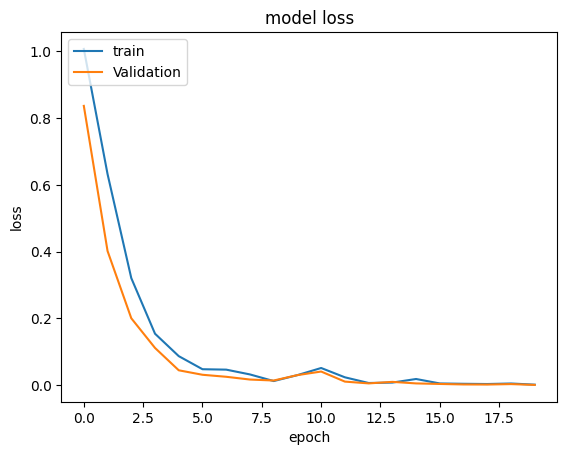

In [83]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

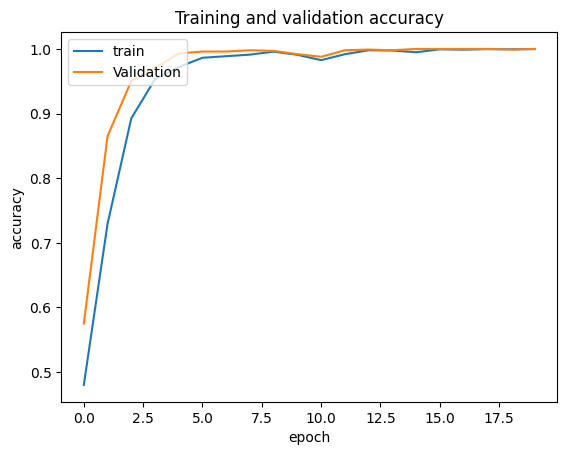

In [84]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 2ms/step
0.9531362653208363
0.9535419056016615


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

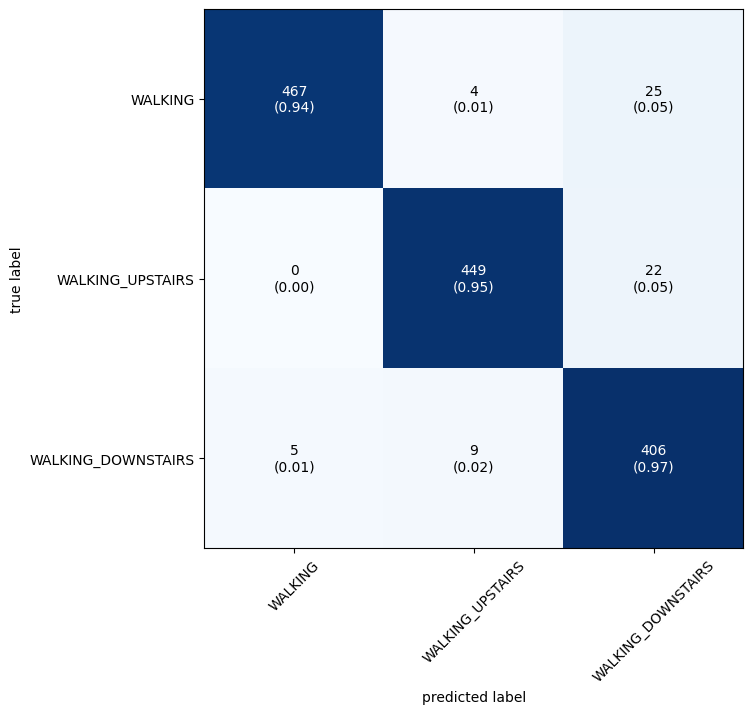

In [85]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# CNN1 - LSTM4

In [86]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_99 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_100 (Time  (None, None, 30, 64)      0         
 Distributed)                                                    
                                                                 
 time_distributed_101 (Time  (None, None, 15, 64)      0         
 Distributed)                                                    
                                                                 
 time_distributed_102 (Time  (None, None, 960)         0         
 Distributed)                                                    
                                                                 
 lstm_23 (LSTM)              (None, None, 100)       

In [87]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
26/26 [==============================] - 6s 58ms/step - loss: 1.0621 - accuracy: 0.4402 - val_loss: 0.9356 - val_accuracy: 0.5680
Epoch 2/20
26/26 [==============================] - 0s 10ms/step - loss: 0.7131 - accuracy: 0.6998 - val_loss: 0.4492 - val_accuracy: 0.8418
Epoch 3/20
26/26 [==============================] - 0s 10ms/step - loss: 0.3806 - accuracy: 0.8627 - val_loss: 0.2485 - val_accuracy: 0.9290
Epoch 4/20
26/26 [==============================] - 0s 10ms/step - loss: 0.2077 - accuracy: 0.9303 - val_loss: 0.0932 - val_accuracy: 0.9746
Epoch 5/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1268 - accuracy: 0.9583 - val_loss: 0.0947 - val_accuracy: 0.9716
Epoch 6/20
26/26 [==============================] - 0s 10ms/step - loss: 0.0851 - accuracy: 0.9729 - val_loss: 0.0323 - val_accuracy: 0.9919
Epoch 7/20
26/26 [==============================] - 0s 10ms/step - loss: 0.0531 - accuracy: 0.9854 - val_loss: 0.0198 - val_accuracy: 0.9939
Epoch 8/20
26

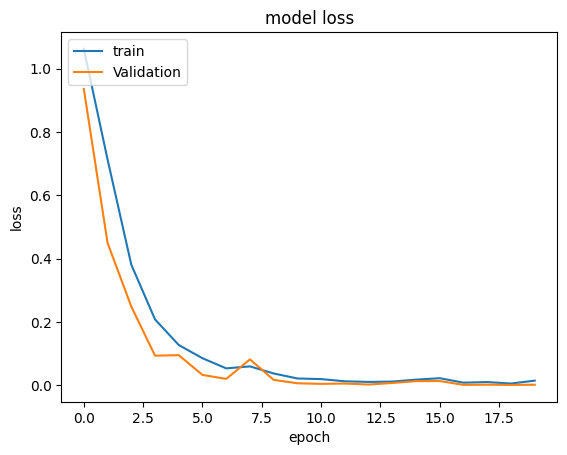

In [88]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

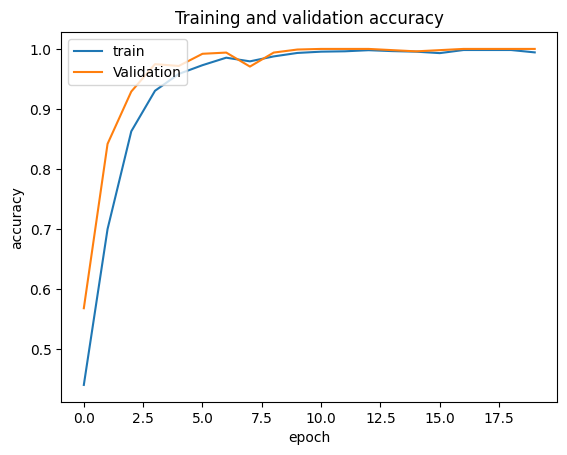

In [89]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 3ms/step
0.9372746935832732
0.9383287393046463


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

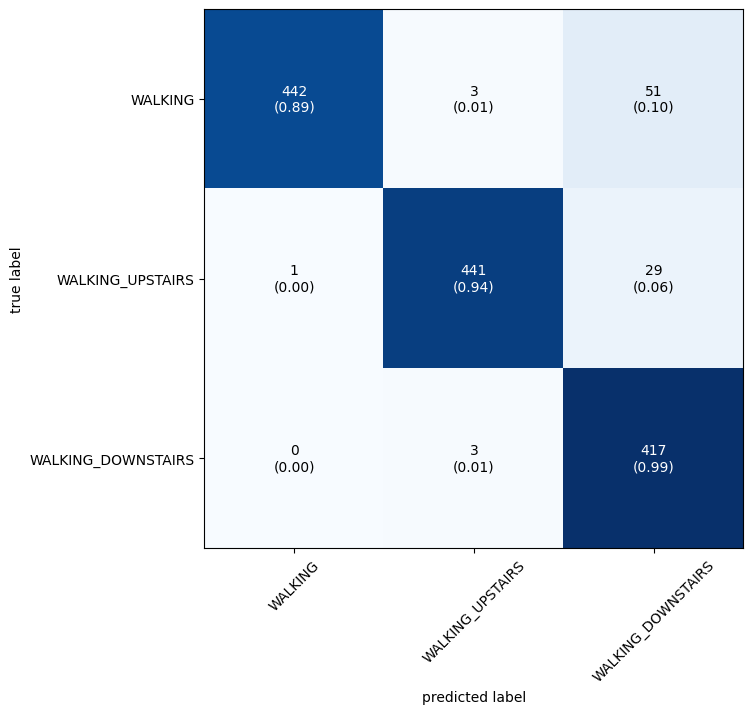

In [90]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# LSTM 5

In [91]:
# define model
model = Sequential()
model.add(TimeDistributed(LSTM(100, return_sequences=True), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100, return_sequences=True)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100, return_sequences=True)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100, return_sequences=True)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100)))

# Use TimeDistributed to flatten the LSTM outputs
model.add(TimeDistributed(Flatten()))

# Pool the time dimension
model.add(GlobalAveragePooling1D())

# Adding Dense layers
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_103 (Time  (None, None, 32, 100)     44000     
 Distributed)                                                    
                                                                 
 time_distributed_104 (Time  (None, None, 32, 100)     0         
 Distributed)                                                    
                                                                 
 time_distributed_105 (Time  (None, None, 32, 100)     80400     
 Distributed)                                                    
                                                                 
 time_distributed_106 (Time  (None, None, 32, 100)     0         
 Distributed)                                                    
                                                                 
 time_distributed_107 (Time  (None, None, 32, 100)   

In [92]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
26/26 [==============================] - 7s 68ms/step - loss: 1.0018 - accuracy: 0.4947 - val_loss: 0.8080 - val_accuracy: 0.7008
Epoch 2/20
26/26 [==============================] - 0s 18ms/step - loss: 0.6497 - accuracy: 0.7406 - val_loss: 0.5363 - val_accuracy: 0.8093
Epoch 3/20
26/26 [==============================] - 0s 18ms/step - loss: 0.3954 - accuracy: 0.8621 - val_loss: 0.2160 - val_accuracy: 0.9280
Epoch 4/20
26/26 [==============================] - 0s 18ms/step - loss: 0.1892 - accuracy: 0.9358 - val_loss: 0.0873 - val_accuracy: 0.9757
Epoch 5/20
26/26 [==============================] - 0s 18ms/step - loss: 0.1021 - accuracy: 0.9702 - val_loss: 0.0501 - val_accuracy: 0.9817
Epoch 6/20
26/26 [==============================] - 1s 19ms/step - loss: 0.0549 - accuracy: 0.9817 - val_loss: 0.0176 - val_accuracy: 0.9929
Epoch 7/20
26/26 [==============================] - 0s 18ms/step - loss: 0.0472 - accuracy: 0.9848 - val_loss: 0.0163 - val_accuracy: 0.9959
Epoch 8/20
26

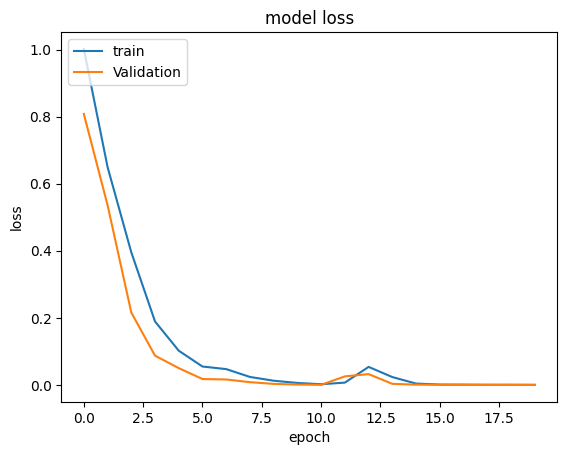

In [93]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

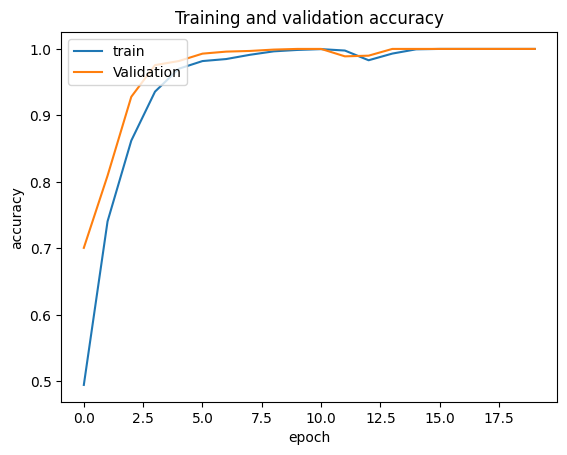

In [94]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 5ms/step
0.9689978370583994
0.9690265023300108


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

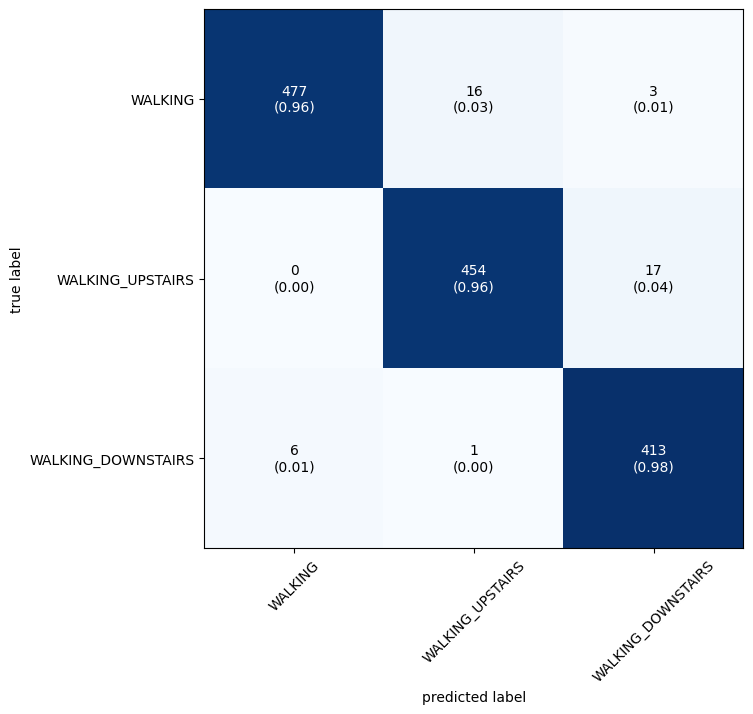

In [95]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))